# Qubit

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error
from helplers.q_chem import *
from helplers.he_bz_pes_plot import plot_inset_benzene


DATA_DIR = f"../data/HeBz"
energy_unit = to_cm_1

## Benzen-Helium, DFT-D4 Correction

- 1-2 $\AA$ 5 points
- 2-3.5 $\AA$ 20 points
- 3.5-5 $\AA$ 5 points


In [5]:
HeBz = np.load(f"{DATA_DIR}/DFT_HeBz.npy", allow_pickle=True).item()
He_gBz = np.load(f"{DATA_DIR}/DFT_He_gBz.npy", allow_pickle=True).item()
Bz_gHe = np.load(f"{DATA_DIR}/DFT_Bz_gHe.npy", allow_pickle=True).item()
cbs_tq = np.load(f"{DATA_DIR}/cbs_tq.npy", allow_pickle=True)

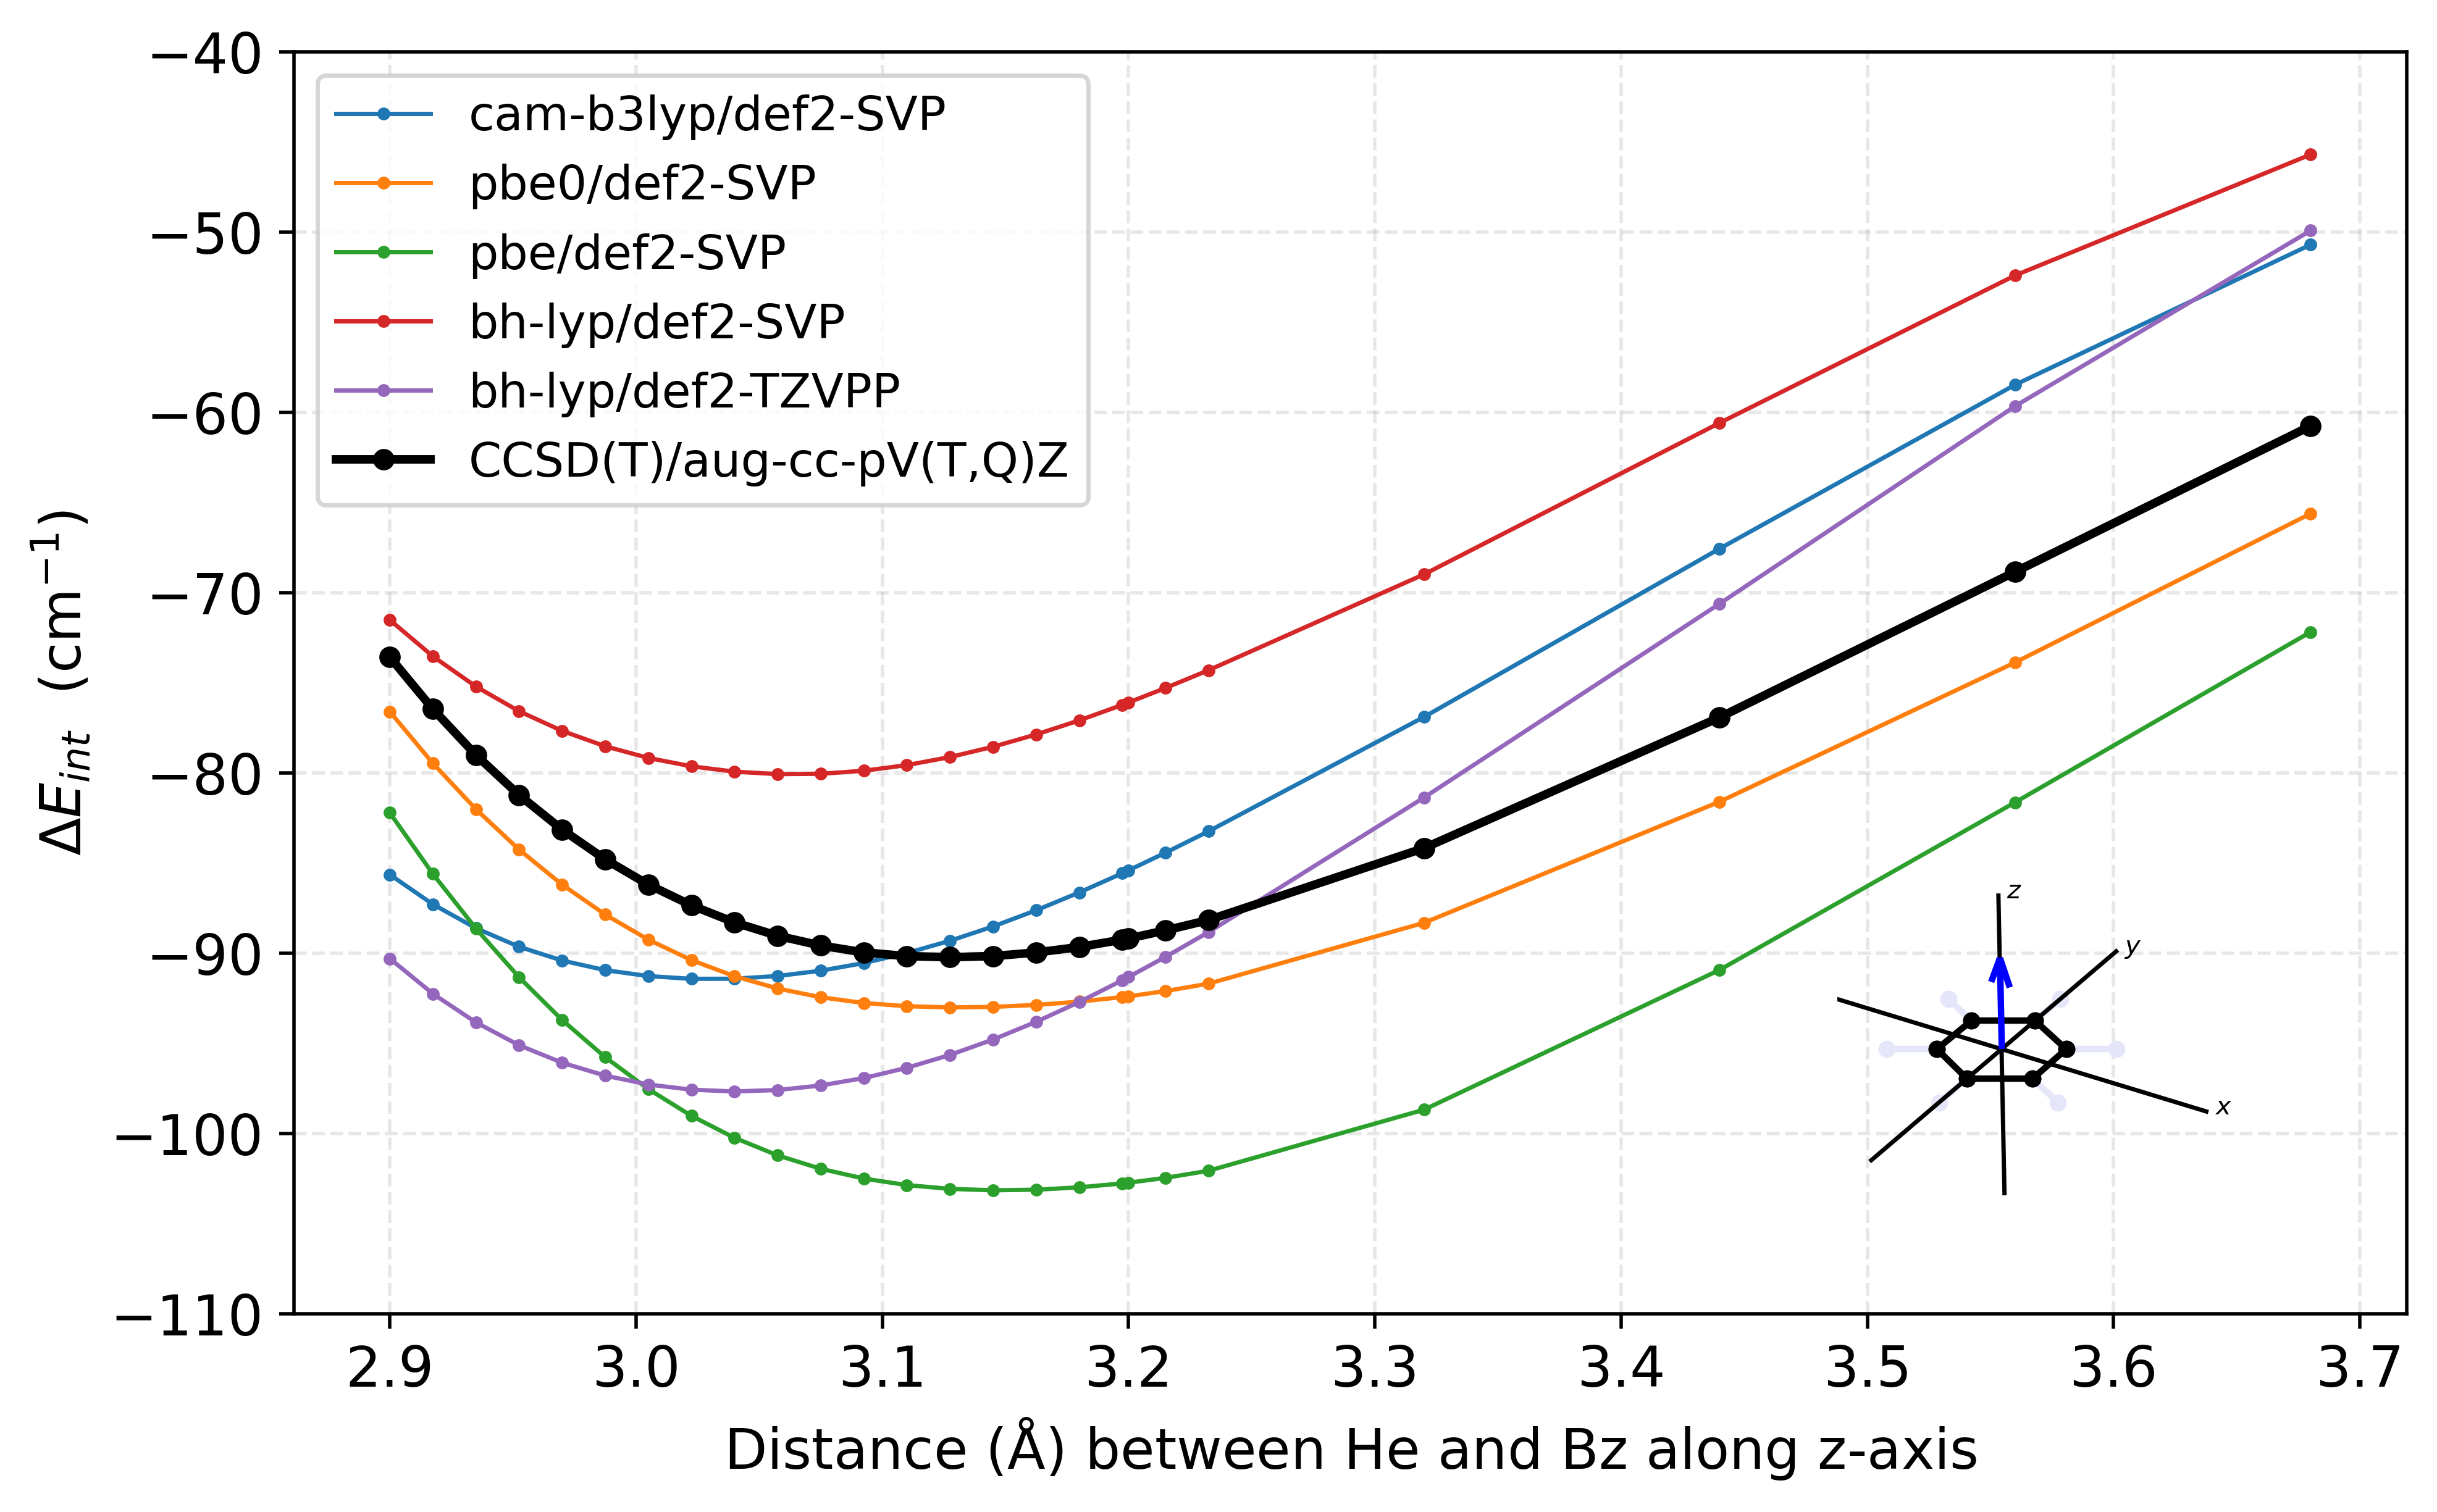

,Functionals,Basis set,MAE,RMSE,MAXE,Start,Min,Well Depth,Max,Distance
0,pbe0,def2-SVP,3.287193,3.349482,5.025784,2.672713,-90.345874,93.018588,36328.981512,3.127500
1,cam-b3lyp,def2-SVP,5.306877,6.368756,12.066878,2.659573,-88.773382,91.432956,36122.451298,3.022500
2,bh-lyp,def2-TZVPP,7.956896,9.219687,16.723971,3.432254,-94.248424,97.680678,36048.355231,3.040000
3,bh-lyp,def2-SVP,10.049822,10.866746,16.441257,3.426117,-76.651993,80.078110,36965.097400,3.057500
4,pbe,def2-SVP,12.143037,12.241791,14.510696,3.180902,-99.980770,103.161672,36330.821365,3.145000


In [6]:
START_IDX = 5
END_IDX = -20
FONT_SIZE = 13
ENERGY_CONVERSION = energy_unit[0]
ENERGY_LABEL = energy_unit[1]

# Define the specific combinations you want to analyze/plot
PLOT_WHITELIST = {
    ("pbe0", "def2-SVP"),
    ("cam-b3lyp", "def2-SVP"),
    ("bh-lyp", "def2-TZVPP"),
    ("bh-lyp", "def2-SVP"),
    ("pbe", "def2-SVP"),
}

# --- Helper Functions ---


def get_sorted_data(res_dict):

    data = np.array(
        [[float(key.split("___")[-1]), float(value)] for key, value in res_dict.items()]
    )
    sorted_indices = np.argsort(data[:, 0])
    return data[sorted_indices]


def calculate_cp_energy(he_bz, he_gbz, bz_ghe):

    distances = he_bz[:, 0]

    energies_hartree = he_bz[:, 1] - he_gbz[:, 1] - bz_ghe[:, 1]
    energies_final = energies_hartree * ENERGY_CONVERSION

    return distances, energies_final

fig, ax = plt.subplots(figsize=(8, 5), dpi=500)

stats_data = []
current_distances = None  # To store distances for the reference plot later

for functional, basis_dict in HeBz.items():
    for basis_set in basis_dict:

        # 1. Check Whitelist
        if (functional, basis_set) not in PLOT_WHITELIST:
            continue

        try:
            # 2. Prepare Data
            data_complex = get_sorted_data(HeBz[functional][basis_set])
            data_mon1 = get_sorted_data(He_gBz[functional][basis_set])
            data_mon2 = get_sorted_data(Bz_gHe[functional][basis_set])

            # 3. Calculate Interaction Energy
            dists, engs_abs = calculate_cp_energy(data_complex, data_mon1, data_mon2)

            # Store for reference plot usage
            current_distances = dists

            last_val = engs_abs[-1]
            engs_rel = engs_abs - last_val


            y_true = cbs_tq[START_IDX:END_IDX]
            y_pred = engs_rel[START_IDX:END_IDX]

            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            maxe = max_error(y_true, y_pred)

            # 6. Collect Statistics
            stats_data.append(
                {
                    "Functionals": functional,
                    "Basis set": basis_set,
                    "MAE": mae,
                    "RMSE": rmse,
                    "MAXE": maxe,
                    "Start": last_val,
                    "Min": np.min(engs_abs),
                    "Well Depth": last_val - np.min(engs_abs),
                    "Max": np.max(engs_abs),
                    "Distance": dists[np.argmin(engs_abs)],
                }
            )

            # 7. Save special case (Logic preserved)
            # if functional == "pbe0" and basis_set == "def2-SVP":
            #     np.save(
            #         f"circumcircumcoronene_{functional}_{basis_set}_energies.npy",
            #         {"distances": dists, "energies": engs_rel},
            #     )

            # 8. Plotting
            ax.plot(
                dists[START_IDX:END_IDX],
                engs_rel[START_IDX:END_IDX],
                label=f"{functional}/{basis_set}",
                linestyle="-",
                linewidth=1,
                marker="o",
                markersize=2,
            )

        except Exception as e:
            print(f"FAILED: {functional}/{basis_set} -> {e}")

# --- Reference Plot (CCSD(T)) ---
try:
    if current_distances is not None:
        ax.plot(
            current_distances[START_IDX:END_IDX],
            cbs_tq[START_IDX:END_IDX],
            label="CCSD(T)/aug-cc-pV(T,Q)Z",
            linewidth=2,
            marker="o",
            markersize=4,
            linestyle="-",
            color="black",
        )
    else:
        print("Warning: No valid data processed. Reference line not plotted.")
except Exception as e:
    print(f"Failed to plot reference: {e}")

# --- Plot Styling ---
ax.set_xlabel(
    r"Distance ($\mathrm{\AA}$) between He and Bz along z-axis", fontsize=FONT_SIZE
)
ax.set_ylabel(r"$\Delta E_{int}$" + f"  ({ENERGY_LABEL})", fontsize=FONT_SIZE)
ax.set_ylim(-110, -40)

# Tick parameters
ax.tick_params(axis="both", which="major", labelsize=FONT_SIZE)

ax.grid(True, alpha=0.3, linestyle="--")

# Legend
ax.legend(loc="upper left", fontsize=FONT_SIZE - 2)

# Optional: Add grid for better readability
# ax.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()

quiver_args = (0, 0.01, 0, 0, 0, 6)
inset_position = [0.65, 0.05, 0.4, 0.4]
plot_inset_benzene(ax, inset_position, *quiver_args)

plt.show()

# --- DataFrame Output ---
df = pd.DataFrame(stats_data)

if not df.empty:
    df = df.sort_values(by="MAE", ascending=True, ignore_index=True)
    # df.to_csv("HeBz_DFT_results.csv")

    # Styling for notebook display
    styled_df = df.style.set_properties(**{"text-align": "left"})
    display(styled_df)
else:
    print("No data collected in DataFrame.")